In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline

In [2]:
base_h5 = os.path.join('all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
299,G,NORM,NaN,mdb292,nan,NaN,NaN,mdb292.pgm,tiffs/mdb292.tif
11,F,NORM,NaN,mdb011,nan,NaN,NaN,mdb011.pgm,tiffs/mdb011.tif
77,F,NORM,NaN,mdb077,nan,NaN,NaN,mdb077.pgm,tiffs/mdb077.tif
305,F,NORM,NaN,mdb298,nan,NaN,NaN,mdb298.pgm,tiffs/mdb298.tif
292,D,NORM,NaN,mdb285,nan,NaN,NaN,mdb285.pgm,tiffs/mdb285.tif


Using TensorFlow backend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4045aec208>]],
      dtype=object)

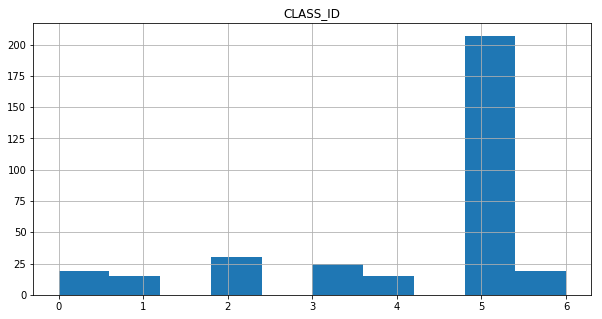

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'SEVERITY']].hist(figsize = (10, 5))
#mammo_df['SEVERITY'].hist(figsize = (10, 5))

## Split Data into Training and Validation

In [14]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(5)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
164,D,NORM,NaN,mdb162,nan,NaN,NaN,mdb162.pgm,tiffs/mdb162.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
101,D,NORM,NaN,mdb101,nan,NaN,NaN,mdb101.pgm,tiffs/mdb101.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
247,D,CALC,38.0,mdb241,M,453.0,678.0,mdb241.pgm,tiffs/mdb241.tif,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
29,G,NORM,NaN,mdb029,nan,NaN,NaN,mdb029.pgm,tiffs/mdb029.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
98,F,NORM,NaN,mdb098,nan,NaN,NaN,mdb098.pgm,tiffs/mdb098.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


New Data Size: 1300 Old Size: 247


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f403e3f2390>,
      dtype=object)

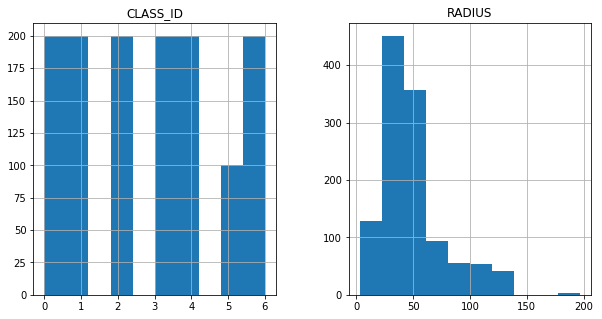

In [15]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (224, 224) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [17]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


#train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
#validation_features, validation_labels = extract_features(validation_dir, validation_size)
#test_features, test_labels = extract_features(test_dir, test_size)

In [18]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images


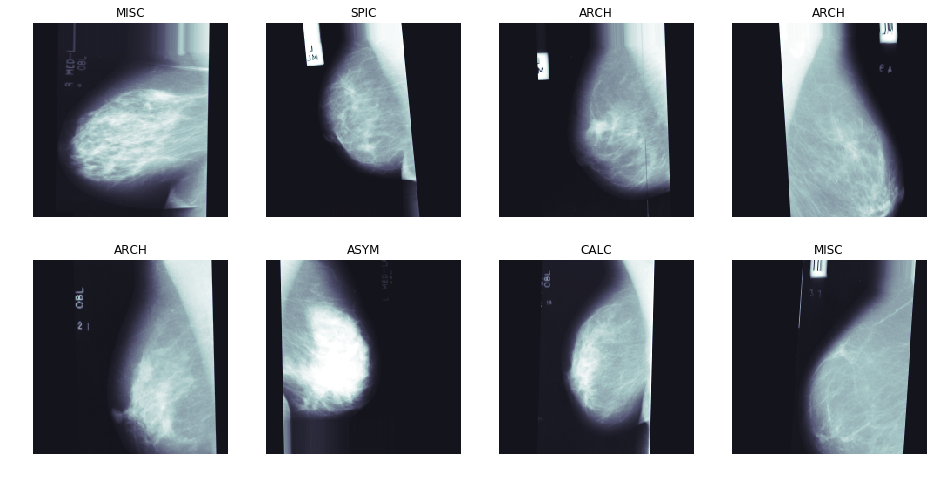

In [19]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % (class_enc.classes_[np.argmax(c_y,-1)]))
    c_ax.axis('off')

 ## VGG16 extractFeatures from Mini MIAS Database

In [28]:
train_gen.samples

1300

In [20]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
#Agregado por mi
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_inceptionv3_weights.best.hdf5".format('mammo_result')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
######################################################################################################

# create the base pre-trained model
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape =  t_x.shape[1:])
# Check architecture
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [31]:
#t_x.shape[0]
feature = conv_base.predict_generator(train_gen,
                                     steps=np.ceil(t_x.shape[0] / 32),
                                     verbose=1)

1/1 [==============================] - 28s 28s/step


In [33]:
feature

<function ndarray.all>

NameError: name 'history' is not defined

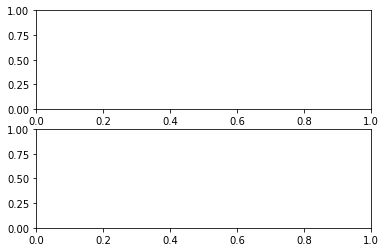

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
predictions = model.predict(test_X)
predictions = np.argmax(predictions, axis=1)

Y_true = np.argmax(test_Y, axis=1)
acc = accuracy_score(Y_true, predictions)

print("Accuracy: {}".format(acc))

Accuracy: 0.060240963855421686
